Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Try Different Mask Percentage

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import LabelSpreading
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
def mask_labels(df, label_col, masked_label, mask_rate=0.95):
    df['keep_label'] = True 
    df.loc[df.sample(frac=mask_rate, random_state=10).index, 'keep_label'] = False
    df[masked_label] = df.apply(lambda r: r[label_col] if r['keep_label']==True else -1, axis=1)
    
    return df


def train_test_split_with_mask(raw_df, label_col, masked_label, cat_features, mask_rate=0.95):
    raw_df = mask_labels(raw_df, label_col, masked_label, mask_rate)
    
    all_y_df = raw_df[[label_col, 'keep_label', masked_label]]
    y = raw_df[masked_label]
    X = raw_df.drop(all_y_df.columns, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)
    all_y_train = all_y_df.iloc[y_train.index]
    all_y_test = all_y_df.iloc[y_test.index]

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    all_y_train.reset_index(inplace=True, drop=True)
    all_y_test.reset_index(inplace=True, drop=True)
    
    encoder = TargetEncoder(cols=cat_features)
    encoded_X_train = encoder.fit_transform(X_train, y_train)
    encoded_X_test = encoder.transform(X_test)
    
    scaler = MinMaxScaler()
    scaled_X_train = scaler.fit_transform(encoded_X_train)
    scaled_X_test = scaler.transform(encoded_X_test)
    
    return scaled_X_train, scaled_X_test, y_train, y_test, all_y_train, all_y_test


def my_semi_supervised(scaled_X_train, y_train, scaled_X_test, all_y_train, all_y_test, label_col):
    model_ls_rbf = LabelSpreading(kernel='rbf',
                              gamma=70,   
                              n_neighbors=20, 
                              max_iter=1000,
                              n_jobs=-1)

    ls_rbf = model_ls_rbf.fit(scaled_X_train, y_train)
    y_pred = ls_rbf.predict(scaled_X_test)
    auc = roc_auc_score(all_y_test[label_col], y_pred)
    recall = recall_score(all_y_test[label_col], y_pred)
    print(f'Testing AUC is {auc}, Testing Recall is {recall}')
    
    all_y_train['ls_rbf'] = ls_rbf.transduction_
    cm= confusion_matrix(all_y_train[all_y_train['masked_deposit']==-1][label_col], all_y_train[all_y_train['masked_deposit']==-1]['ls_rbf'], normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls_rbf.classes_)
    disp.plot()
    plt.show()

In [5]:
label_col = 'deposit'
masked_label = 'masked_deposit'

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
print(raw_df.shape)
print(raw_df[label_col].value_counts())

raw_df.head()

(11162, 17)
0    5873
1    5289
Name: deposit, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [6]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
mask_rate_lst = [0.95, 0.8, 0.5, 0.2]

Mask Rate: 0.95
Testing AUC is 0.6134136676393241, Testing Recall is 0.5526315789473685


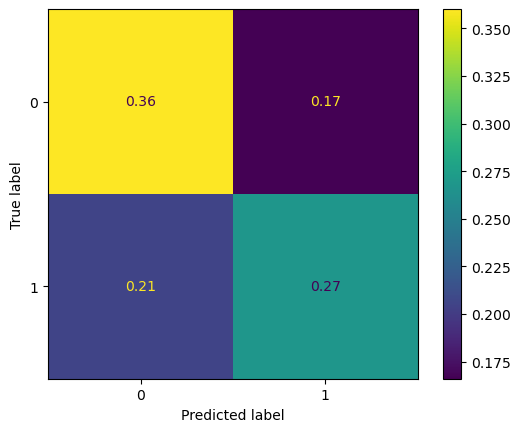


Mask Rate: 0.8
Testing AUC is 0.7116946695623914, Testing Recall is 0.6341275941583397


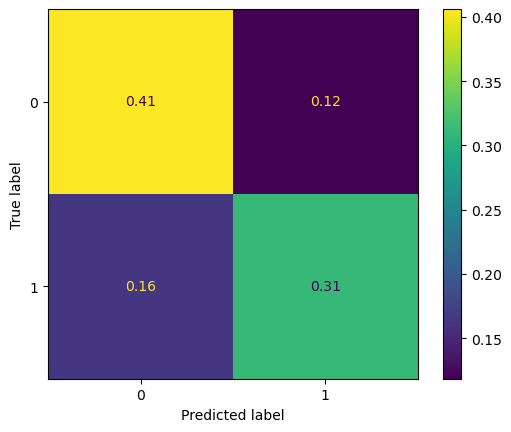


Mask Rate: 0.5
Testing AUC is 0.7353520840679588, Testing Recall is 0.6460244648318043


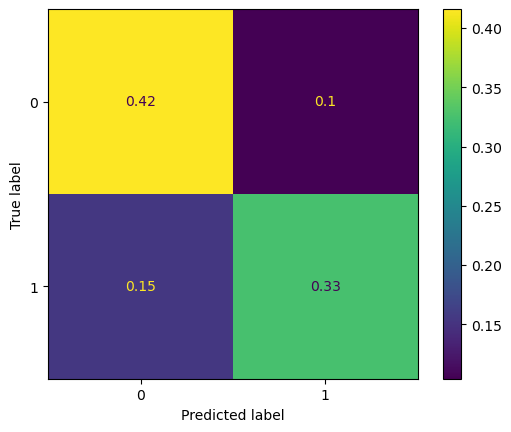


Mask Rate: 0.2
Testing AUC is 0.7242888582907059, Testing Recall is 0.6459909228441755


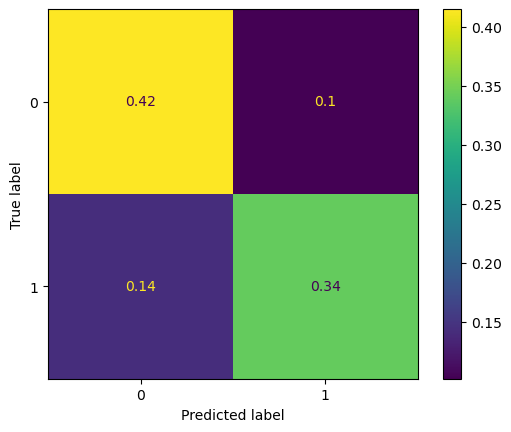

In [7]:
for mask_rate in mask_rate_lst:
    print(f'Mask Rate: {mask_rate}')
    scaled_X_train, scaled_X_test, y_train, y_test, all_y_train, all_y_test = train_test_split_with_mask(raw_df, label_col, masked_label, cat_features, mask_rate)
    my_semi_supervised(scaled_X_train, y_train, scaled_X_test, all_y_train, all_y_test, label_col)
    print()